# BEFORE YOU START

* Make sure you have the latest julia, julip, ace, installed
* Change the JULIA_UTILS_PATH in ace_interface.py to point to your castle folder
* Copy the delta_silicon.xyz data to "../data/Si_2018/delta_silicon.xyz"

In [1]:
from ase.io import read
import numpy as np
import sys
from matplotlib import pyplot as plt

import joblib
import pickle
sys.path.insert(0,"../")
from castle import train_ensamble_linear_model, ASEMLCalculator, AceGlobalRepresentation, train_linear_model
from castle import get_forces_and_energies, get_virials, get_nat, dump, load, print_score

def split_dataset(N, training_percentage, seed=20):
    np.random.seed(seed)
    ids = list(range(N))
    np.random.shuffle(ids)
    return ids[:int(training_percentage*N)], ids[int(training_percentage*N):]

%load_ext autoreload
%autoreload 2

/home/claudio/.local/lib/python3.8/site-packages/julia/core.py:687: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


# Load structures

In [2]:
# Load xyz data
input_file =  "/home/claudio/postdoc/integrated_potentials/data/Si_2018/delta_silicon.xyz"
frames_ = read(input_file, index = ':')
    
# Wrap positions so rascal does not complain
for ff in frames_:
    ff.wrap(eps=1e-11)
energy_name = 'dft_energy'
force_name = 'dft_force'
virial_name = 'dft_virial'

In [3]:
tags = set()
for ff in frames_:
    tags.add(ff.info['config_type'])
print(tags)

{'sh', 'sp', 'st12', 'surface_111_pandey', 'dia', 'isolated_atom', 'sp2', 'bc8', 'decohesion', 'surface_001', 'fcc', 'surface_111_3x3_das', 'bt', 'bcc', 'screw_disloc', 'amorph', '111adatom', 'crack_110_1-10', 'interstitial', 'hcp', 'divacancy', 'hex_diamond', 'liq', 'surface_111', 'crack_111_1-10', 'surface_110', 'vacancy'}


In [4]:
# build a potential for diamond phase only
frames = []
for ff in frames_:
    if ff.info['config_type'] in ['amorph', 'bt', 'dia', 'liq', 'fcc', 'bcc', 'hcp', 'hex_diamond']:
        try:
            len(ff.info['dft_virial'])
            frames.append(ff)
        except KeyError:
            pass

# Build a model

Compute representation

In [5]:
# Create training and validation set
tr_ind, val_ind = split_dataset(len(frames), 0.8)
tr_frames = [frames[s] for s in tr_ind]
val_frames = [frames[s] for s in val_ind]
e_t, f_t = get_forces_and_energies(tr_frames, energy_name = energy_name, force_name = force_name)
e_val, f_val = get_forces_and_energies(val_frames, energy_name = energy_name, force_name = force_name)
s_val = get_virials(val_frames, virial_name)
nat_val = get_nat(val_frames)

N = 8               # Body order
maxdeg = 10         # Number of basis (?)
rcut = 5.0          # Radial Cutoff
r0 = 1.0            # Lowest radius for basis
reg = 1e-8          # Ridge regularizer
species = 14        # Atomic number of species


representation = AceGlobalRepresentation(N, maxdeg, rcut, species, r0, reg, 
                                         energy_name=energy_name, force_name=force_name, virial_name=virial_name)

In [14]:
#  compute features
features = representation.transform(frames)
#  save them
# dump('./features.xz', features)

Train a linear model

In [15]:
# load the features
# features = load('./features.xz')
noise = 1e-6
# get the subset of features for training
tr_features = features.get_subset(tr_ind)
# train the model
model = train_linear_model(tr_features, noise, e_t, f_t)

MAE=0.04 RMSE=0.07 SUP=0.36 R2=0.91
MAE=0.26 RMSE=0.41 SUP=3.95 R2=0.45


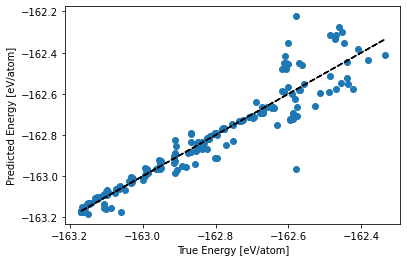

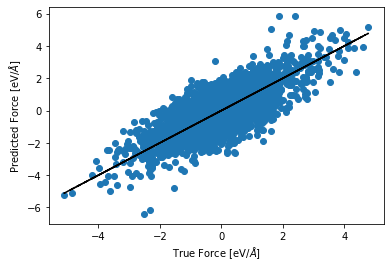

In [16]:
# evaluate its performances
val_features = features.get_subset(val_ind)
ep = model.predict(val_features)
fp = model.predict_forces(val_features)


print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())
# print_score(vp.flatten(), s_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

## train an ensemble of linear models

In [17]:
n_clusters = 5
n_neighbours = 10

In [18]:
# features = load('./features.xz')

In [19]:
noise = 1e-8
# get the subset of features for training
tr_features = features.get_subset(tr_ind)
# train the model
model =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                        n_neighbours=n_neighbours, 
                         hyper=n_clusters, clustering='e_gmm')

MAE=0.04 RMSE=0.09 SUP=0.33 R2=0.83
MAE=0.18 RMSE=0.33 SUP=2.43 R2=0.60


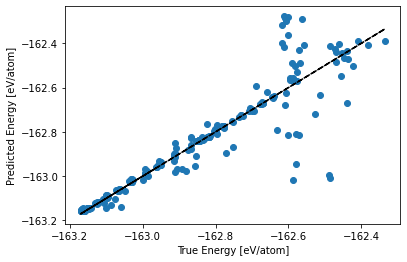

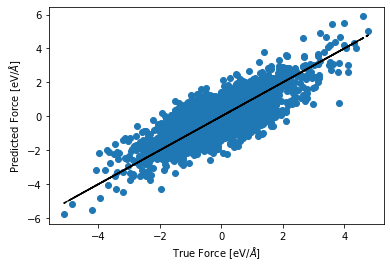

In [20]:
# evaluate its performances
val_features = features.get_subset(val_ind)
ep = model.predict(val_features)
fp = model.predict_forces(val_features)
# vp = model.predict_stress(val_features)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())
# print_score(vp.flatten(), s_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

In [21]:
# # save the model
# dump('./model.xz',model)

# use the model for cell optimization

In [22]:
from ase.lattice.cubic import FaceCenteredCubic, Diamond
from scipy.optimize import leastsq, minimize
from ase.build import bulk
from ase.optimize import LBFGS
from ase.optimize import FIRE
from ase.optimize import MDMin
from ase.md.langevin import Langevin
from ase import constraints
from ase.constraints import StrainFilter

In [24]:
# model = load('./model.xz')

In [25]:
calc = ASEMLCalculator(model, model.representation)

In [26]:
latticeconstant = 4.5
atoms = bulk('Si', 'diamond', a=latticeconstant, cubic=True)
atoms.set_calculator(calc)
filt = StrainFilter(atoms)
opt = FIRE(filt)
opt.run(5e-4)
enRef = atoms.get_potential_energy()
volRef = atoms.get_volume()
atoms.get_cell(),enRef, volRef**(1/3)

/home/claudio/.local/lib/python3.8/site-packages/julia/core.py:687: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(
/home/claudio/.local/lib/python3.8/site-packages/julia/core.py:687: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 17:06:02    -1292.980368*       0.0000


(Cell([4.5, 4.5, 4.5]), array([-1292.98036756]), 4.499999999999999)